In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.stats import pearsonr
from scipy.io import loadmat
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
%matplotlib inline
os.sys.path.append('/scratch/cl6707/Projects/neuro_interp/data/NSD')
rootpath = '/scratch/cl6707/Projects/neuro_interp/data/NSD'
os.sys.path.append('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsd')

/tmp/ipykernel_2663892/2777984076.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
root_dir = os.getcwd() + '/'
output_dir = root_dir + "output/"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print ("Current dir: %s" % root_dir)

Current dir: /scratch/cl6707/Projects/neuro_interp/Neural_Interpretation/notebooks/


# Load dataset

In [3]:
nsd_root = "/scratch/cl6707/Projects/neuro_interp/data/NSD/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
synth_root = nsd_root + "nsddata_stimuli/stimuli/nsdsynthetic/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"
synth_design_file = nsd_root + "nsddata/experiments/nsdsynthetic/nsdsynthetic_expdesign.mat"
stim_file       = stim_root + "nsd_stimuli.hdf5"
synth_file      = synth_root + "nsdsynthetic_stimuli.hdf5"

In [7]:
from src.file_utility import  load_mask_from_nii,view_data

# def load_mask_from_nii(mask_nii_file):
#     return nib.load(mask_nii_file).get_fdata()
    
def iterate_roi(group, voxelroi, roimap, group_name=None):
    for k,g in enumerate(group):
        g_name = ('' if group_name is None else group_name[k])
        mask = np.zeros(shape=voxelroi.shape, dtype=bool)
        for i,roi in enumerate(g):
            if group_name is None:
                g_name += roimap[roi] + ('-' if i+1<len(g) else '')
            mask = np.logical_or(mask, voxelroi==roi)
        yield mask, g_name

# Make early visual cortex masks

In [5]:
subjects = [1] #, 2, 3, 4, 5, 6, 7, 8] we only downloaded subject 1

In [8]:
roi_map = {1: 'V1v', 2: 'V1d', 3: 'V2v', 4: 'V2d', 5: 'V3v', 6: 'V3d', 7: 'v4'}
group_names = ['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'V4',]
group = [[1], [2], [3], [4], [5], [6], [7],]

for k,s in enumerate(subjects):
    print ('--------  subject %d  -------' % s)
    voxel_roi_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%s)
    brain_nii_shape = voxel_roi_full.shape
    print (brain_nii_shape)

    general_mask_full = (voxel_roi_full>0).flatten().astype(bool)
    voxel_mask = general_mask_full
    voxel_idx = np.arange(len(general_mask_full))[voxel_mask]
    voxel_roi = voxel_roi_full.flatten()[voxel_mask]
    
    print ('mask selection length = %d'%np.sum(voxel_mask))
    print ('mask total length = %d'%len(voxel_mask))
    _ = view_data(brain_nii_shape, voxel_idx,  np.ones_like(voxel_idx), save_to=mask_root \
                  + "subj%02d/func1pt8mm/brainmask_vcventral_1.0.nii"%s)

--------  subject 1  -------
(81, 104, 83)
mask selection length = 4657
mask total length = 699192


# Make visual cortex masks

In [15]:
roi_map = {1: 'V1v', 2: 'V1d', 3: 'V2v', 4: 'V2d', 5: 'V3v', 6: 'V3d', 7: 'hV4', 8: 'VO1', 9: 'VO2', \
           10: 'PHC1', 11: 'PHC2', 12: 'MST', 13: 'hMT', 14: 'LO2', 15: 'LO1', 16: 'V3b', 17: 'V3a', \
           18: 'IPS0', 19: 'IPS1', 20: 'IPS2', 21: 'IPS3', 22: 'IPS4', 23: 'IPS5', 24: 'SPL1', 25: 'FEF',\
           0: 'other'}

for k,s in enumerate(subjects):
    print ('--------  subject %d  -------' % s)
    voxel_roi_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%s)
    voxel_kast_full     = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(s))
    general_mask_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(s))
    ###
    
    brain_nii_shape = voxel_roi_full.shape
    print (brain_nii_shape)

    ###
    voxel_mask_full = (voxel_roi_full>0).flatten().astype(bool)
    voxel_joined_roi_full = np.copy(voxel_kast_full.flatten())  # take the kastner rois
    voxel_joined_roi_full[voxel_mask_full] = voxel_roi_full.flatten()[voxel_mask_full] # overwrite the prf visual rois
    voxel_joined_mask_full = (voxel_joined_roi_full>0).flatten().astype(bool)
    ###
    
    voxel_mask = voxel_joined_mask_full
    voxel_idx = np.arange(len(voxel_joined_mask_full))[voxel_mask]
    voxel_roi = voxel_joined_roi_full[voxel_mask]
        
    print ('(kastner selection length = %d)'%np.sum(voxel_kast_full>0))
    print ('mask selection length = %d'%np.sum(voxel_mask))
    print ('mask total length = %d'%len(voxel_mask))
    _ = view_data(brain_nii_shape, voxel_idx,  np.ones_like(voxel_idx), save_to=mask_root \
                  + "subj%02d/func1pt8mm/brainmask_nsdgeneral_1.0.nii"%s)
                  

--------  subject 1  -------
(81, 104, 83)
(kastner selection length = 11067)
mask selection length = 11930
mask total length = 699192


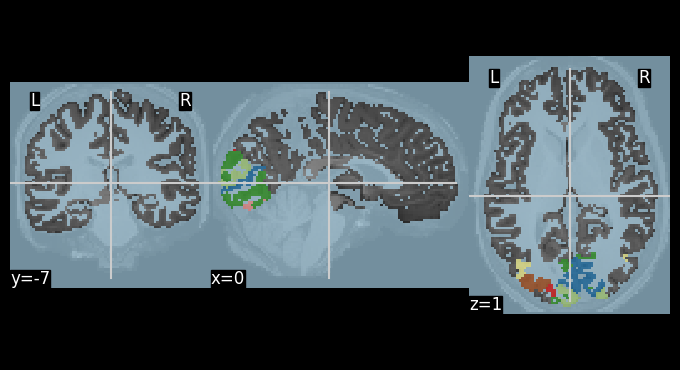

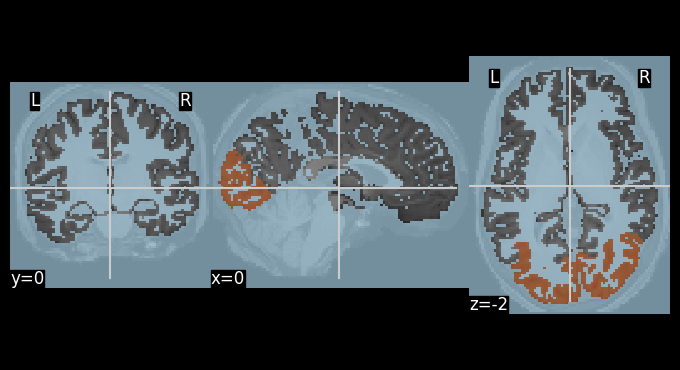

In [28]:
# voxel_roi_full
subject = 1
brain_r2_full     = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/R2.nii.gz"%(subject,)
brain_mask_full   = mask_root + "subj%02d/func1pt8mm/brainmask.nii.gz"%(subject)
brain_anat_full   = mask_root + "subj%02d/func1pt8mm/T1_to_func1pt8mm.nii.gz"%(subject)
brain_seg_full    = mask_root + "subj%02d/func1pt8mm/aseg.nii.gz"%(subject)
brain_roi_full    = mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(subject)
general_mask_full = mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(subject)

# plot the mask
from nilearn.plotting import plot_roi
from nilearn import image
from nilearn import plotting
from nilearn import datasets
from nilearn.image import mean_img

plot_roi(brain_roi_full, bg_img=brain_anat_full, cmap='Paired')
plotting.show()




In [26]:
volume_brain_mask

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

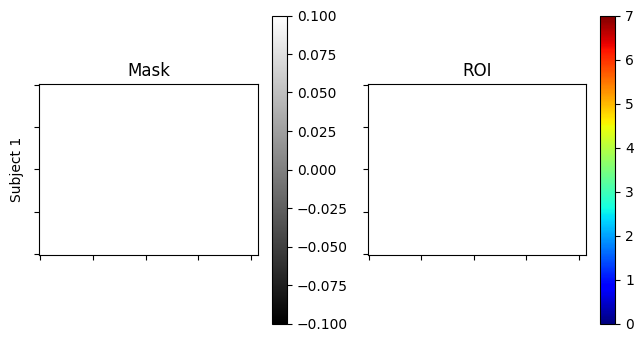

In [17]:
slice_idx = 25
plt.figure(figsize=(12, 4))
    
volume_brain_mask = view_data(brain_nii_shape, voxel_idx, np.ones_like(voxel_idx), save_to=None)
volume_brain_roi  = view_data(brain_nii_shape, voxel_idx, voxel_roi, save_to=None)
##
plt.subplot(1,3,1)
plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Mask')
plt.colorbar()
_=plt.ylabel('Subject %d'%s)
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,3,2)
plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.clim([0,7])
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])